<img src="img/fifa.png",width=400,height=400,align=center>

## Predicting the 2018 FIFA World Cup Winner
In this Jupyter Notebook, I'm going to develop a Machine Learning model to try to predict the outcomes of all games in World Cup 2018, which also means predicting the winner of the championship. 

We're going first to do some exploratory analysis on two datasets obtained from Kaggle. Then, we're going to do some feature engineering in order to select which features are the most relevant to the case in point, do some data manipulation, choose an ML model and finally deploy it on the dataset. Let's go!

### 1) Getting things ready
First step: import the necessary packages and read the files into pandas Dataframes. The first dataset `wc` features many lots of information on the teams participating in the tournament, while the second dataset `results` consists of a historical records of roughly all international matches played since... well, since the origins of football!

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read .csv files
wc = pd.read_csv('datasets/World Cup 2018 Dataset.csv')
results = pd.read_csv('datasets/results.csv')

In [3]:
wc.head()

,Team,Group,Previous appearances,Previous titles,Previous finals,Previous semifinals,Current FIFA rank,First match against,Match index,history with first opponent W-L,history with first opponent goals,Second match against,Match index.1,history with second opponent W-L,history with second opponent goals,Third match against,Match index.2,history with third opponent W-L,history with third opponent goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN
3,Uruguay,A,12.0,2.0,2.0,5.0,21.0,Egypt,2.0,1.0,2.0,Saudi Arabia,18.0,-1.0,-1.0,Russia,33.0,0.0,0.0,NaN
4,Porugal,B,6.0,0.0,0.0,2.0,3.0,Spain,3.0,-12.0,-31.0,Morocco,19.0,-1.0,-2.0,Iran,35.0,2.0,5.0,NaN


In [4]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,London,England
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,London,England
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland


### 2) Exploring the data
After taking a quick look at both datasets, I believe the `results` dataset is going to be more useful to our analysis, since we need data on past matches in order to predict future outcomes. It would be impossible to elaborate a model solely on the `wc` dataset.

We'll start by creating two auxiliary columns that will tell us the absolute **goal difference** in each match and the **outcome** of each match (that is, which team won, or whether the match ended in a tie). I believe these pieces of information should be useful when we arrive at the feature engineering discussion.

The Dataframe has an enormous amount of match records, but not all of them are actually useful for our analysis. We need to start thinking about which **features** exactly will be the most relevant for the ML model we are going to use. 

This is a very complex and time-consuming part of every Data Science project roadmap, so we are going to spend a good chunk of time here.

As you'll be able to see, I sometimes **pivot my analysis** because I realize some feature will not be as useful as I thought it would be. However, for documentation purposes, I left all steps of the exploratory analysis in this notebook.

In [5]:
# Adding new column for winner of each match
tie='Tie'
for i in range(len(results)):
    if results.home_score[i] < results.away_score[i]:
        results.loc[i,'winning_team']=results.loc[i,'away_team']
    elif results.home_score[i] > results.away_score[i]:
        results.loc[i,'winning_team']=results.loc[i,'home_team']
    elif results.home_score[i] == results.away_score[i]:
        results.loc[i,'winning_team']=tie

In [6]:
# Adding new column for goal difference in matches
results['goal_difference'] = abs(results.home_score - results.away_score)

In [7]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,Tie,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Tie,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,Scotland,3


Let's work with a subset of the dataset: one that includes only games played by England. This will help us focus on what features would be interesting to observe for one country, and then we can later expand to all countries participating in the World Cup.

In [8]:
# Slice the dataset and create new 'england' Dataframe
df = results[(results['home_team'] == 'England') | (results['away_team'] == 'England')]
england = df.iloc[:]
england.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,Tie,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Tie,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,Scotland,3


In [9]:
# Loop for creating a new column 'year'
year = []
for row in england['date']:
    year.append(int(row[:4]))
england['match_year'] = year

# Slicing the dataset to see how many matches took place from 1930 onwards (the year of the first ever World Cup)
england_1930 = england[england.match_year >= 1930]
england_1930.count()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


date               810
home_team          810
away_team          810
home_score         810
away_score         810
tournament         810
city               810
country            810
winning_team       810
goal_difference    810
match_year         810
dtype: int64

Now let's try quickly visualizing the data to see which was the most common game outcome for England, and the distribution of games throughout the years.

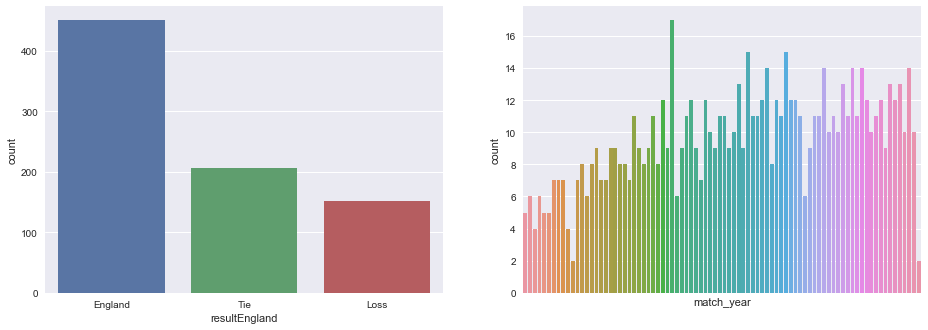

In [10]:
# Create auxiliary DataFrame for substituting other countries' names for 'Loss'
winrate = []
for row in england_1930['winning_team']:
    if row != 'England' and row != 'Tie':
        winrate.append('Loss')
    else:
        winrate.append(row)
dfwinrate = pd.DataFrame(winrate, columns=['resultEngland'])

# Plot with Seaborn and show
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15.7, 5.27)
sns.set(style="darkgrid")
sns.countplot(x='resultEngland', data=dfwinrate, ax = ax[0])
sns.countplot(x='match_year', data=england_1930, ax = ax[1])
plt.xticks(np.arange(min(england_1930.match_year), max(england_1930.match_year), 100))
plt.show()

Getting win rates for every country that will participate in the World Cup should be a useful information for our analysis. Maybe we can use these winning rates to predict the most likely outcomes of each match in the tournament?

However, there are many features in this dataset that won't help. The World Cup is always held in one place (in this year, Russia), so the location of previous matches won't add much to our analysis. The column 'tournament' will also be of little help, since all matches in which we are going to apply the model will be 'FIFA World Cup'. Thus, we can start defining more clearly our model's scope and limitations.

### 3) Defining the project

**Objective**: to create a Machine Learning model capable of predicting the outcomes of football games in the 2018 FIFA World Cup.

**Features**: Results of historical matches since the beginning of the championship (1930) for all participating teams.

**Limitations and obeservations**: I considered gathering data about the ranking of each team for all matches in the dataset; this way we would be able to see if the overall quality of the team impacted on the outcome of each match. However, the FIFA ranking was created only in the 90s, thus eliminating a huge portion of the dataset. I also searched for more ways to assess the quality of each team in each year, but such information was impossible to gather. A realiable proxy would be to average out the rating of each player in a team via their FIFA ratings (the game, not the organization). However, the game also started being realeased only in the 90s, turning this approach impossible. Therefore, for this project in particular, we will stick with historical match records to build a very simple model.

#### 3.1) Narrowing the 2018 World Cup participants

In [11]:
# Create a DF with all participating teams
wc_teams = ['Australia', ' Iran', 'Japan', 'Korea Republic', 
            'Saudi Arabia', 'Egypt', 'Morocco', 'Nigeria', 
            'Senegal', 'Tunisia', 'Costa Rica', 'Mexico', 
            'Panama', 'Argentina', 'Brazil', 'Colombia', 
            'Peru', 'Uruguay', 'Belgium', 'Croatia', 
            'Denmark', 'England', 'France', 'Germany', 
            'Iceland', 'Poland', 'Portugal', 'Russia', 
            'Serbia', 'Spain', 'Sweden', 'Switzerland']

# Filter the 'results' dataframe to show only teams in this years' world cup, from 1930 onwards
df_teams_home = results[results['home_team'].isin(wc_teams)]
df_teams_away = results[results['away_team'].isin(wc_teams)]
df_teams = pd.concat((df_teams_home, df_teams_away))
df_teams.count()

date               20565
home_team          20565
away_team          20565
home_score         20565
away_score         20565
tournament         20565
city               20565
country            20565
winning_team       20565
goal_difference    20565
dtype: int64

#### 3.2) Manipulating the data

Let's now slice the dataset to show only games from 1930 onwards. Football was probably a very different game before it started getting competitive with the introduction of the World Cup.

In [12]:
# Loop for creating a new column 'year'
year = []
for row in df_teams['date']:
    year.append(int(row[:4]))
df_teams['match_year'] = year

# Slicing the dataset to see how many matches took place from 1930 onwards (the year of the first ever World Cup)
df_teams30 = df_teams[df_teams.match_year >= 1930]
df_teams30.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference,match_year
1230,1930-01-01,Spain,Czechoslovakia,1,0,Friendly,Barcelona,Spain,Spain,1,1930
1231,1930-01-12,Portugal,Czechoslovakia,1,0,Friendly,Lisbon,Portugal,Portugal,1,1930
1237,1930-02-23,Portugal,France,2,0,Friendly,Porto,Portugal,Portugal,2,1930
1238,1930-03-02,Germany,Italy,0,2,Friendly,Frankfurt am Main,Germany,Italy,2,1930
1240,1930-03-23,France,Switzerland,3,3,Friendly,Colombes,France,Tie,0,1930


All seems to be well. We have a dataset of a reasonable size to train our model. Now, let's drop all the columns we are not going to use (unfortunately, the majority of them). Essentially we will end up with a dataset which show the countries of each match and the outcome. Simple as that - let's see if it leads to something.

In [13]:
df_teams30 = df_teams30.drop(['date', 'home_score', 'away_score', 'tournament', 'city', 'country', 'goal_difference', 'match_year'], axis=1)
df_teams30.head(5)

,home_team,away_team,winning_team
1230,Spain,Czechoslovakia,Spain
1231,Portugal,Czechoslovakia,Portugal
1237,Portugal,France,Portugal
1238,Germany,Italy,Italy
1240,France,Switzerland,Tie


In [14]:
df_teams30.shape

(19472, 3)

#### 3.3) Building the ML model

First, let's modify the "Y" (prediction label) in order to simplify our model's processing. The winning_team column will show "2" if the home team has won, "1" if it was a tie, and "0" if the away team has won.

In [15]:
df_teams30 = df_teams30.reset_index(drop=True)
df_teams30.loc[df_teams30.winning_team == df_teams30.home_team, 'winning_team']= 2
df_teams30.loc[df_teams30.winning_team == 'Tie', 'winning_team']= 1
df_teams30.loc[df_teams30.winning_team == df_teams30.away_team, 'winning_team']= 0

df_teams30.head()

,home_team,away_team,winning_team
0,Spain,Czechoslovakia,2
1,Portugal,Czechoslovakia,2
2,Portugal,France,2
3,Germany,Italy,0
4,France,Switzerland,1


We will now set some dummies for the home_team and away_team variables, because otherwise we wouldn't be able to deploy a scikit-learn model on the dataset, since they are presented as categorical variables.

In [16]:
# Get dummy variables
final = pd.get_dummies(df_teams30, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

final.head()

,winning_team,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,home_team_Australia,...,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Splitting the data into test and train for finding the hold out data accuracy

In [17]:
from sklearn.model_selection import train_test_split

# Separate X and y sets
X = final.drop(['winning_team'], axis=1)
y = final["winning_team"]
y = y.astype('int')

# Separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)

Now we should be ready to try an ML model! Let's try Logistic Regression.

In [18]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
score = logreg.score(X_train, y_train)
score2 = logreg.score(X_test, y_test)

print("Training set accuracy: ", '%.3f'%(score))
print("Test set accuracy: ", '%.3f'%(score2))

Training set accuracy:  0.575
Test set accuracy:  0.550


Our model yields an accuracy of 57% on the training set and 55% on the test set. It is not great, but at least it is better than a simple random estimator, which would yield 33% accuracy if the data was uniformly distributed, considering there are 3 possible outcomes for each match (home win, tie or away win).  Let's try a bunch of other models and see which one stands out.

**ATTENTION!**

The following block of code takes a long while to run. You can just skip this block if you're in a hurry, since it will not affect the following ones.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


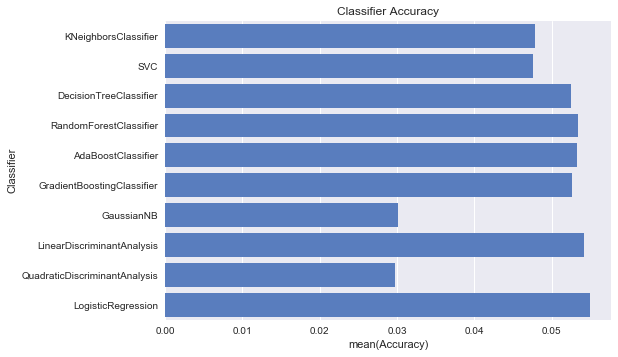

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]


log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

# Loop to do fit and predictions of each classifier into the dataset
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    
    # Storing each score into a dict
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

# Storing the results in a DataFrame to be visualized
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.show()

For some incredible reason, the Logistic Regression we tried earlier remained the best model for predicting scores, even though its accuracy is still subpar. Let's stick with the model, then. Later, we could try thinking of ways to increase the model's accuracy, maybe by tuning some parameters, or using more sophisticated prediction models like neural networks. 

One important aspect when creating our prediction dataframe is how we will distribute the teams in the "home_team" column and the "away_team" column, since there are no "home" or "away" teams in World Cup games. So, let's first find out if there's in fact a bigger winrate for teams playing at home. Remember: 
"2" means home team win;
"1" means a tie;
"0" means away team win.

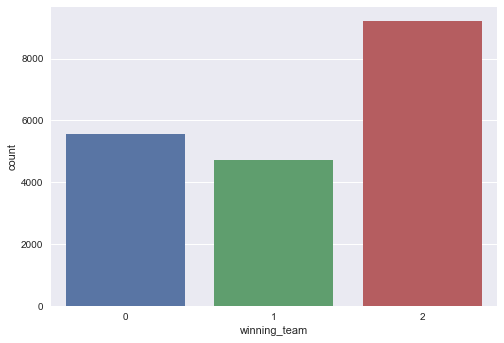

In [20]:
sns.countplot(x='winning_team', data=df_teams30)
plt.show()

There is, indeed, a bigger amount of wins for teams playing at home. Therefore, in the next section, we will use a very simplistic (but not too far-fetched) assumption for creating our predictions dataframe: the team which is positioned higher on the FIFA Ranking will be considered "favourite" for the match, and therefore, will be positioned under the "home_teams" column. You'll understand better below.

### 4) Creating the prediction set with 2018 FIFA World Cup data

<img src="img/groups.jpg",width=600,height=600,align=center>
<caption><center> <u>**Group stage configuration** </u> </center></caption>

At last!

Now, let's start creating the necessary dataframe in which we'll deploy our model!
First, we'll start loading a dataset `ranking` containing FIFA rankings as of April 2018, and then a dataset `fixtures` containing the fixtures for the group stage of the championship.

After that, we'll do some quick data cleaning in order to fit our dataframe to the model's dimensional requirements and organize the teams in "home" and "away" teams according to their position in the FIFA rankings.

In [21]:
# Loading new datasets
ranking = pd.read_csv('datasets/fifa_rankings.csv') # Obtained from https://us.soccerway.com/teams/rankings/fifa/?ICID=TN_03_05_01
fixtures = pd.read_csv('datasets/fixtures.csv') # Obtained from https://fixturedownload.com/results/fifa-world-cup-2018

# List for storing the group stage games
pred_set = []

In [22]:
# Create new columns with ranking position of each team
fixtures.insert(1, 'first_position', fixtures['Home Team'].map(ranking.set_index('Team')['Position']))
fixtures.insert(2, 'second_position', fixtures['Away Team'].map(ranking.set_index('Team')['Position']))

# We only need the group stage games, so we have to slice the dataset
fixtures = fixtures.iloc[:48, :]
fixtures.tail()

,Round Number,first_position,second_position,Date,Location,Home Team,Away Team,Group,Result
43,3,6.0,25.0,27/06/2018 21:00,Nizhny Novgorod Stadium,Switzerland,Costa Rica,Group E,NaN
44,3,60.0,10.0,28/06/2018 17:00,Volgograd Stadium,Japan,Poland,Group H,NaN
45,3,28.0,16.0,28/06/2018 17:00,Samara Stadium,Senegal,Colombia,Group H,NaN
46,3,55.0,14.0,28/06/2018 21:00,Saransk Stadium,Panama,Tunisia,Group G,NaN
47,3,13.0,3.0,28/06/2018 21:00,Kaliningrad Stadium,England,Belgium,Group G,NaN


In [23]:
# Loop to add teams to new prediction dataset based on the ranking position of each team
for index, row in fixtures.iterrows():
    if row['first_position'] < row['second_position']:
        pred_set.append({'home_team': row['Home Team'], 'away_team': row['Away Team'], 'winning_team': None})
    else:
        pred_set.append({'home_team': row['Away Team'], 'away_team': row['Home Team'], 'winning_team': None})
        
pred_set = pd.DataFrame(pred_set)
backup_pred_set = pred_set

pred_set.head()

,away_team,home_team,winning_team
0,Saudi Arabia,Russia,None
1,Egypt,Uruguay,None
2,Morocco,Iran,None
3,Spain,Portugal,None
4,Australia,France,None


Great! Now we already have a clean dataset with all group stage games for the FIFA World Cup 2018. Now we will just need to create some dummy variables, and then deploy an ML model into this DF. We can start by using our Logistic Regression Model.

In [24]:
# Get dummy variables and drop winning_team column
pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Add missing columns compared to the model's training dataset
missing_cols = set(final.columns) - set(pred_set.columns)
for c in missing_cols:
    pred_set[c] = 0
pred_set = pred_set[final.columns]

# Remove winning team column
pred_set = pred_set.drop(['winning_team'], axis=1)

pred_set.head()

,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,home_team_Australia,home_team_Austria,...,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5) Deploying the model

At last, it's time to deploy our model and start predicting the matches away. Let's go!

In [25]:
predictions = logreg.predict(pred_set)
for i in range(fixtures.shape[0]):
    print(backup_pred_set.iloc[i, 1] + " and " + backup_pred_set.iloc[i, 0])
    if predictions[i] == 2:
        print("Winner: " + backup_pred_set.iloc[i, 1])
    elif predictions[i] == 1:
        print("Tie")
    elif predictions[i] == 0:
        print("Winner: " + backup_pred_set.iloc[i, 0])
    print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
    print('Probability of Tie: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1]))
    print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
    print("")


Russia and Saudi Arabia
Winner: Russia
Probability of Russia winning:  0.673
Probability of Tie:  0.231
Probability of Saudi Arabia winning:  0.096

Uruguay and Egypt
Winner: Uruguay
Probability of Uruguay winning:  0.563
Probability of Tie:  0.355
Probability of Egypt winning:  0.081

Iran and Morocco
Tie
Probability of Iran winning:  0.328
Probability of Tie:  0.371
Probability of Morocco winning:  0.300

Portugal and Spain
Winner: Spain
Probability of Portugal winning:  0.313
Probability of Tie:  0.326
Probability of Spain winning:  0.361

France and Australia
Winner: France
Probability of France winning:  0.648
Probability of Tie:  0.222
Probability of Australia winning:  0.130

Argentina and Iceland
Winner: Argentina
Probability of Argentina winning:  0.827
Probability of Tie:  0.142
Probability of Iceland winning:  0.031

Peru and Denmark
Winner: Peru
Probability of Peru winning:  0.437
Probability of Tie:  0.185
Probability of Denmark winning:  0.378

Croatia and Nigeria
Winner:

Great! We've got some outcome predictions. As expected, the model greatly favoured home team wins, and only predicted 2 ties and 4 away team victories out of all group stage games. Now, we are going to predict the next games (round of 16, quarter-finals, semi-finals and the big final).

For the round of 16, we know we're going to pair up the winner of a group with the second-placed team in the next one. I will hard-code the games for this next step because there are relatively few matches and creating the standings for each group would require way too much time. I've used the following website to simulate the matches, giving always the 1-0 outcome whenever a team won, as goal difference is not being analyzed in this project: https://ultra.zone/2018-FIFA-World-Cup-Group-Stage#group=a

The image below shows the knockout stage according to our predicted outcomes.

<img src="img/round16.jpg",width=700,height=700,align=center>
<caption><center> <u>**Predicted knockout stage configuration** </u> </center></caption>

We'll have to separate the nations into 'home' teams and 'away' teams again. I'll try a slightly different approach since in this time we don't have a clean, neat dataset of fixtures like last time. Instead, I'll first hard-code a list of tuples with the teams in each match, and iterate through this list, extracting the ranking position of each team and the using this information to separate them later into a cleaner DataFrame. Then, we can apply the model at this cleaner dataset.

Actually, I'll create a **function** to do this, since we'll have to do the same procedure for the next rounds of the competition.

In [26]:
# List of tuples before we arrange the teams in home and away
group_16 = [('Uruguay', 'Spain'),
            ('France', 'Croatia'),
            ('Brazil', 'Mexico'),
            ('England', 'Colombia'),
            ('Portugal', 'Russia'),
            ('Argentina', 'Peru'),
            ('Germany', 'Switzerland'),
            ('Poland', 'Belgium')]

In [27]:
def clean_and_predict(matches, ranking, final, logreg):

    # Initialization of auxiliary list for data cleaning
    positions = []

    # Loop to retrieve each team's position according to FIFA ranking
    for match in matches:
        positions.append(ranking.loc[ranking['Team'] == match[0],'Position'].iloc[0])
        positions.append(ranking.loc[ranking['Team'] == match[1],'Position'].iloc[0])
    
    # Creating the DataFrame for prediction
    pred_set = []

    # Initializing iterators for while loop
    i = 0
    j = 0

    # 'i' will be the iterator for the 'positions' list, and 'j' for the list of matches (list of tuples)
    while i < len(positions):
        dict1 = {}

        # If position of first team is better, he will be the 'home' team, and vice-versa
        if positions[i] < positions[i + 1]:
            dict1.update({'home_team': matches[j][0], 'away_team': matches[j][1]})
        else:
            dict1.update({'home_team': matches[j][1], 'away_team': matches[j][0]})

        # Append updated dictionary to the list, that will later be converted into a DataFrame
        pred_set.append(dict1)
        i += 2
        j += 1

    # Convert list into DataFrame
    pred_set = pd.DataFrame(pred_set)
    backup_pred_set = pred_set

    # Get dummy variables and drop winning_team column
    pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

    # Add missing columns compared to the model's training dataset
    missing_cols2 = set(final.columns) - set(pred_set.columns)
    for c in missing_cols2:
        pred_set[c] = 0
    pred_set = pred_set[final.columns]

    # Remove winning team column
    pred_set = pred_set.drop(['winning_team'], axis=1)

    # Predict!
    predictions = logreg.predict(pred_set)
    for i in range(len(pred_set)):
        print(backup_pred_set.iloc[i, 1] + " and " + backup_pred_set.iloc[i, 0])
        if predictions[i] == 2:
            print("Winner: " + backup_pred_set.iloc[i, 1])
        elif predictions[i] == 1:
            print("Tie")
        elif predictions[i] == 0:
            print("Winner: " + backup_pred_set.iloc[i, 0])
        print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ' , '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
        print('Probability of Tie: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1])) 
        print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
        print("")

In [28]:
clean_and_predict(group_16, ranking, final, logreg)

Spain and Uruguay
Winner: Spain
Probability of Spain winning:  0.594
Probability of Tie:  0.202
Probability of Uruguay winning:  0.204

France and Croatia
Winner: France
Probability of France winning:  0.475
Probability of Tie:  0.253
Probability of Croatia winning:  0.272

Brazil and Mexico
Winner: Brazil
Probability of Brazil winning:  0.713
Probability of Tie:  0.196
Probability of Mexico winning:  0.091

England and Colombia
Winner: England
Probability of England winning:  0.561
Probability of Tie:  0.329
Probability of Colombia winning:  0.110

Portugal and Russia
Winner: Portugal
Probability of Portugal winning:  0.342
Probability of Tie:  0.333
Probability of Russia winning:  0.325

Argentina and Peru
Winner: Argentina
Probability of Argentina winning:  0.722
Probability of Tie:  0.208
Probability of Peru winning:  0.070

Germany and Switzerland
Winner: Germany
Probability of Germany winning:  0.669
Probability of Tie:  0.188
Probability of Switzerland winning:  0.143

Belgium a

Well, the model played safe and betted on the "favourite" teams, but we stumbled upon an unexpected problem. We can't have Ties in Round of 16 matches, like it happened in the Portugal X Russia game! Being so, I'll just arbitrarily pick the outcome with the second-highest probability, which is a Portugal win. I do not encourage this practice.

Let's take a look at the matches in the next round. From now on, we'll just have to prepare a list with the matches and then call our last function. 

<img src="img/quarter.jpg",width=700,height=700,align=center>
<caption><center> <u>**Predicted quarter-finals configuration** </u> </center></caption>

In [29]:
# List of matches
quarters = [('Spain', 'France'),
            ('Portugal', 'Argentina'),
            ('Brazil', 'England'),
            ('Germany', 'Belgium')]

In [30]:
clean_and_predict(quarters, ranking, final, logreg)

France and Spain
Winner: France
Probability of France winning:  0.393
Probability of Tie:  0.292
Probability of Spain winning:  0.315

Portugal and Argentina
Winner: Argentina
Probability of Portugal winning:  0.334
Probability of Tie:  0.297
Probability of Argentina winning:  0.368

Brazil and England
Winner: Brazil
Probability of Brazil winning:  0.558
Probability of Tie:  0.257
Probability of England winning:  0.185

Germany and Belgium
Winner: Germany
Probability of Germany winning:  0.608
Probability of Tie:  0.240
Probability of Belgium winning:  0.152



Wow, Portugal and Argentina was a close call! And again, since we had a tie, we'll do our little trick and select the outcome with second-highest probability, which is ~~unfortunately~~ Argentina winning the match.

<img src="img/semi.jpg",width=700,height=700,align=center>
<caption><center> <u>**Predicted semi-finals configuration** </u> </center></caption>

In [31]:
# List of matches
semi = [('France', 'Brazil'),
        ('Argentina', 'Germany')]

In [32]:
clean_and_predict(semi, ranking, final, logreg)

Brazil and France
Winner: Brazil
Probability of Brazil winning:  0.638
Probability of Tie:  0.203
Probability of France winning:  0.158

Germany and Argentina
Winner: Germany
Probability of Germany winning:  0.462
Probability of Tie:  0.235
Probability of Argentina winning:  0.303



All right, time for the big game!

Being Brazilian, and not having exactly forgotten about our last encounter with the Germans in the 2014 World Cup, I would be quite excited to see such a finale.

<img src="img/final.jpg",width=600,height=600,align=center>
<caption><center> <u>**Predicted final!** </u> </center></caption>

In [33]:
# The big game
finals = [('Brazil', 'Germany')]

In [34]:
clean_and_predict(finals, ranking, final, logreg)

Germany and Brazil
Winner: Brazil
Probability of Germany winning:  0.382
Probability of Tie:  0.206
Probability of Brazil winning:  0.412



Well, can't say that I'm happy with this result. But congrats, Germany.

It was fun.

### 5) Possible next steps

As a first experiment toying around with data mining, machine learning and Jupyter Notebooks, I can say that I'm quite satisfied with the tools and skills I learned. However, the model is not without its problems. I highlight below two deficiencies of the way this project was structured:

1) **Lack of relevant features**. There were almost no significant features for our model to learn, only a series of matches between two teams and the outcome. We could think of some more features to be added, but the problem was getting the data necessary from games that are far away in the past. Thus, I sticked to working with a very simple dataset.

2) **Home team / Away team bias**. This is probably one of the biggest concerns. At one point, since I could not determine which were the home and away teams, I simply awarded the team with the highest FIFA Ranking position the honor of being the home team. And as we saw in the historical data, those teams had bigger chances of winning. The original dataset had the home and away features, and if we just stripped down the dataset from these attributes, we would be left with actually very few data points. Ideally, we would be able to give as input to our model a tuple containing the two teams, without distinction of home/away, and it would not have a bias against any of them. This is an interesting point to be developed later on.

That being said, there are lots of things we could do on this project as next steps. 

I) **Ensemble modelling**: We could try using multiple learning algorithms in order to achieve a higher accuracy.

II) **More sophisticated feature engineering**: I'm a complete beginner to feature engineering, and to be honest I didn't do a great work in this area. We could try doing some feature transformation or creation on our dataset to increase model accuracy.

III) **Dimensionality reduction**: Because of our dummy variables, the training set had a huge amount of features, but they did not mean much. Maybe there's a way to represent this training data in lower dimensional spaces.

IV) **Algorithm tuning**: I could play around the the multiple parameters of the algorithms I tested, and maybe some of them would actually yield a better accuracy than our good ol' logistic regression.

So, I hope you enjoyed reading this notebook. I plan on working in new projects, and if all goes well, you'll get to see my skills improving with time. 

Cheers and happy coding! :)